In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [65]:
pip install mplcursors

Note: you may need to restart the kernel to use updated packages.


In [66]:
import mplcursors

In [67]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.appName("SpotifyAnalysis").getOrCreate()

In [68]:
data = spark.read.csv("hdfs://namenode:9000/data.csv", header=True, inferSchema=True)
data_by_artist = spark.read.csv("hdfs://namenode:9000/data_by_artist.csv", header=True, inferSchema=True)
data_by_genres = spark.read.csv("hdfs://namenode:9000/data_by_genres.csv", header=True, inferSchema=True)
data_by_year = spark.read.csv("hdfs://namenode:9000/data_by_year.csv", header=True, inferSchema=True)
data_w_genres = spark.read.csv("hdfs://namenode:9000/data_w_genres.csv", header=True, inferSchema=True)

In [69]:
dropped_data_columns = ["instrumentalness", "id"]
droppped_data_by_artist_columns = ["instrumentalness", "mode"]
dropped_data_by_genres_columns = ["instrumentalness", "speechiness"]
dropped_data_by_year_columns = ["instrumentalness", "speechiness", "mode"]
dropped_data_w_genres = ["instrumentalness", "speechiness"]

min_data = data.drop(*dropped_data_columns).dropna(how="all")
min_data_by_artist = data_by_artist.drop(*droppped_data_by_artist_columns).dropna(how="all")
min_data_by_genres = data_by_genres.drop(*dropped_data_by_genres_columns).dropna(how="all")
min_data_by_year = data_by_year.drop(*dropped_data_by_year_columns).dropna(how="all")
min_data_w_genres = data_w_genres.drop(*dropped_data_w_genres).dropna(how="all")

In [70]:
min_data.createOrReplaceTempView("data")
min_data_by_artist.createOrReplaceTempView("data_by_artist")
min_data_by_genres.createOrReplaceTempView("data_by_genres")
min_data_by_year.createOrReplaceTempView("data_by_year")
min_data_w_genres.createOrReplaceTempView("data_w_genres")

+--------------------+------------------+------------------+
|              genres|  avg_danceability|        avg_energy|
+--------------------+------------------+------------------+
|  experimental house|             0.929|             0.573|
|          guam indie|              0.92|             0.319|
|       dutch hip hop|0.9109999999999999|             0.635|
|       dutch rap pop|            0.9074|0.7092666666666666|
|british children'...|             0.906|             0.596|
|    indie deutschrap|             0.903|             0.253|
|     trance mexicano|             0.902|0.8370000000000001|
|            footwork|             0.897|             0.568|
|       funk paulista|0.8959999999999999|             0.675|
|           proto-rap|             0.893|             0.515|
+--------------------+------------------+------------------+



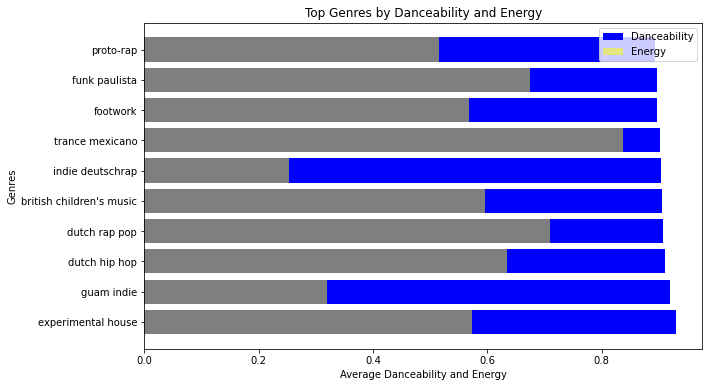

In [71]:
query1 = spark.sql("""
    SELECT genres, AVG(danceability) AS avg_danceability, AVG(energy) AS avg_energy
    FROM data_by_genres
    GROUP BY genres
    ORDER BY avg_danceability DESC, avg_energy DESC
    LIMIT 10
""")
query1.show()

df1 = query1.toPandas()

#Plotting
plt.figure(figsize=(10, 6))
plt.barh(df1["genres"], df1["avg_danceability"], color="blue", label="Danceability")
plt.barh(df1["genres"], df1["avg_energy"], color="yellow", alpha=0.5, label="Energy")
plt.xlabel("Average Danceability and Energy")
plt.ylabel("Genres")
plt.title("Top Genres by Danceability and Energy")
plt.legend()
mplcursors.cursor(hover=True)
plt.show()

+----+--------------------+
|year|avg_duration_minutes|
+----+--------------------+
|1921|  43.422861111111104|
|1922|  27.578291079812207|
|1923|  29.657060360360358|
|1924|  31.841117937853102|
|1925|  30.831154076738606|
|1926|   26.14694291243348|
|1927|  30.832266395663954|
|1928|  35.804651070578906|
|1929|   28.16656880252101|
|1930|   32.52504755717256|
|1931|  28.592237577639754|
|1932|   32.62489541832669|
|1933|   32.70320959961408|
|1934|  31.559354382929648|
|1935|   36.68737450592885|
|1936|   36.80153106060607|
|1937|  37.202759766615934|
|1938|  41.529516585100595|
|1939|          36.9336775|
|1940|  30.371324083333334|
+----+--------------------+
only showing top 20 rows



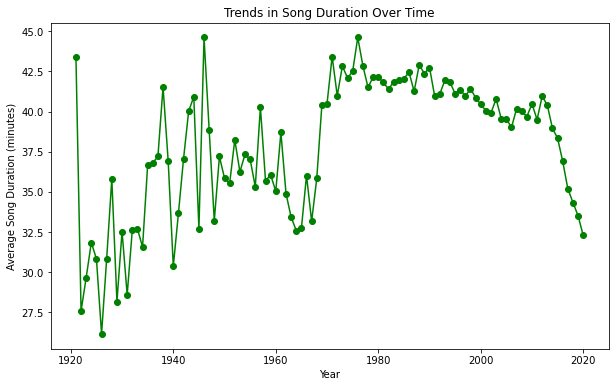

In [72]:
query2 = spark.sql("""
    SELECT year, AVG(duration_ms) / 6000 AS avg_duration_minutes
    FROM data_by_year
    GROUP BY year
    ORDER BY year ASC
""")
query2.show()

df2 = query2.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df2["year"], df2["avg_duration_minutes"], marker='o', color="green")
plt.xlabel("Year")
plt.ylabel("Average Song Duration (minutes)")
plt.title("Trends in Song Duration Over Time")
mplcursors.cursor(hover=True)
plt.show()

+-----------------+-----+
|          artists|count|
+-----------------+-----+
| Francisco Canaro| 3169|
| Эрнест Хемингуэй| 2422|
|Эрих Мария Ремарк| 2136|
|    Frank Sinatra| 1459|
|  Ignacio Corsini| 1256|
|Vladimir Horowitz| 1200|
| Arturo Toscanini| 1146|
|   Billie Holiday| 1103|
|      Johnny Cash| 1061|
|    Elvis Presley| 1023|
+-----------------+-----+



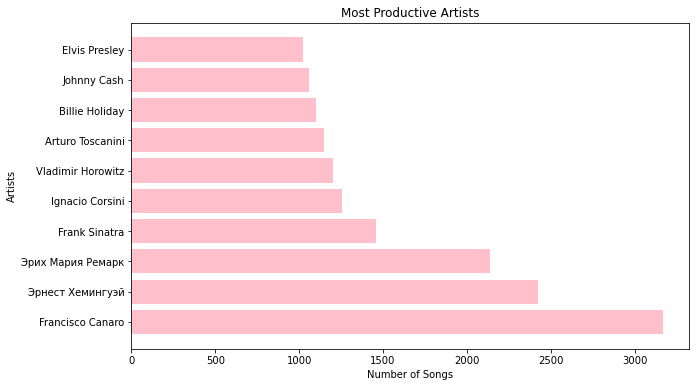

In [73]:
query3 = spark.sql("""
    SELECT artists, count
    FROM data_by_artist
    ORDER BY count DESC
    LIMIT 10
""")
query3.show()

df3= query3.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(df3["artists"], df3["count"], color="pink")
plt.xlabel("Number of Songs")
plt.ylabel("Artists")
plt.title("Most Productive Artists")
mplcursors.cursor(hover=True)
plt.show()


+----+-------------------+
|year|   percent_explicit|
+----+-------------------+
|1921|  4.666666666666667|
|1922|                0.0|
|1923|                0.0|
|1924|                0.0|
|1925|                0.0|
|1926| 17.126269956458636|
|1927|  1.951219512195122|
|1928|                0.0|
|1929| 45.168067226890756|
|1930|0.36382536382536385|
|1931| 31.262939958592135|
|1932|                0.0|
|1933|0.43415340086830684|
|1934|                0.0|
|1935| 17.918313570487484|
|1936|                0.0|
|1937|   1.06544901065449|
|1938|                0.0|
|1939|                0.0|
|1940|              19.45|
+----+-------------------+
only showing top 20 rows



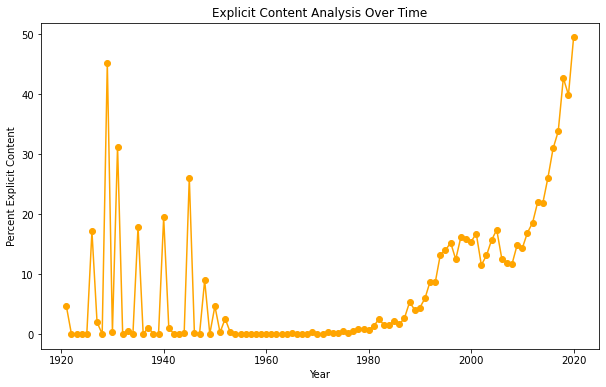

In [74]:
query4 = spark.sql("""
    SELECT year,
            SUM(CASE WHEN explicit = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100 AS percent_explicit
            FROM data
            GROUP BY year
            ORDER BY year ASC
""")
query4.show()

df4 = query4.toPandas()

plt.figure(figsize=(10, 6))
plt.plot(df4["year"], df4["percent_explicit"], marker='o', color="orange")
plt.xlabel("Year")
plt.ylabel("Percent Explicit Content")
plt.title("Explicit Content Analysis Over Time")
mplcursors.cursor(hover=True)
plt.show()

+--------------------+------------------+
|              genres| avg_duration_mins|
+--------------------+------------------+
|bulgarian experim...| 39.70977777777777|
|histoire pour enf...|27.033333333333335|
|musique pour enfants|27.033333333333335|
|             oratory|          24.48805|
|          microtonal|20.144441666666665|
|               432hz| 17.48145555555555|
|      hungarian folk|12.224261111111108|
|  magyar alternative|12.224261111111108|
|progressive power...|11.939116666666667|
|  canadian post-rock| 11.15123888888889|
+--------------------+------------------+



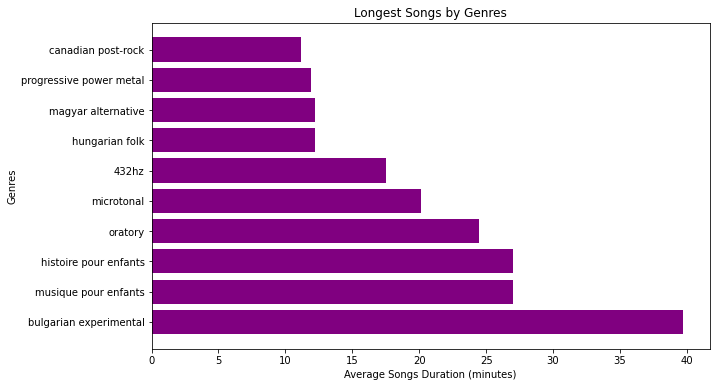

In [75]:
query5 = spark.sql("""
    SELECT genres, AVG(duration_ms)/60000 AS avg_duration_mins
    FROM data_by_genres
    GROUP BY genres
    ORDER BY avg_duration_mins DESC
    LIMIT 10
""")
query5.show()

query5_df = query5.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(query5_df["genres"], query5_df["avg_duration_mins"], color="purple")
plt.xlabel("Average Songs Duration (minutes)")
plt.ylabel("Genres")
plt.title("Longest Songs by Genres")
#plt.gca().invert_yaxis()
mplcursors.cursor(hover=True)
plt.show()

#longest songs by genre

+----+--------------------+----------------+----------+
|year|             artists|max_danceability|song_count|
+----+--------------------+----------------+----------+
|1989|        ['Tone-Loc']|           0.988|         3|
|2012|['Pitbull', 'Trin...|           0.986|         1|
|2007|['Young Boss', 'T...|           0.986|         1|
|2018|      ['ITSOKTOCRY']|           0.985|         1|
|2015|      ['Astra Teck']|           0.983|         2|
|1997|       ['Daft Punk']|            0.98|        12|
|2020|        ['347aidan']|            0.98|         1|
|1984|['The Jacksons', ...|            0.98|         1|
|1990|     ['Vanilla Ice']|            0.98|         3|
|2017|    ['XXXTENTACION']|           0.979|        18|
+----+--------------------+----------------+----------+



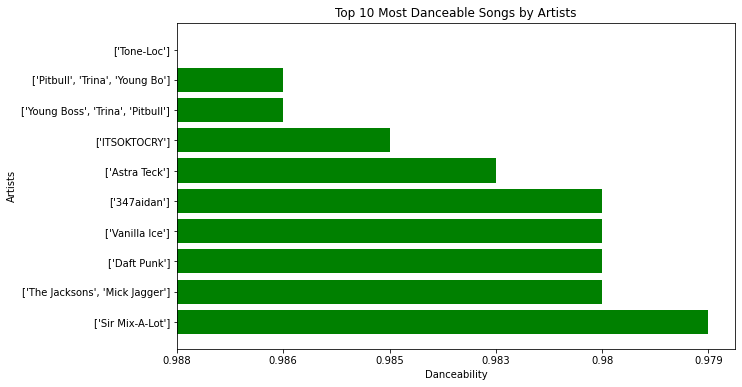

In [76]:
query6 = spark.sql("""
    SELECT year, artists, MAX(danceability) AS max_danceability, COUNT(name) as song_count
    FROM data 
    GROUP BY year, artists
    ORDER BY max_danceability DESC
    LIMIT 10
""")
query6.show()

query6_df = query6.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(query6_df["artists"], query6_df["max_danceability"], color="green")
plt.xlabel("Danceability")
plt.ylabel("Artists")
plt.title("Top 10 Most Danceable Songs by Artists")
plt.gca().invert_yaxis()
mplcursors.cursor(hover=True)
plt.show()

#Top10 most danceable songs by year

+--------------------+---------+
|             artists|num_songs|
+--------------------+---------+
|['Эрнест Хемингуэй']|     1211|
|['Эрих Мария Рема...|     1068|
|['Francisco Canaro']|      942|
|   ['Frank Sinatra']|      630|
| ['Ignacio Corsini']|      628|
|   ['Elvis Presley']|      504|
|     ['Johnny Cash']|      484|
|       ['Bob Dylan']|      474|
|['The Rolling Sto...|      471|
|  ['The Beach Boys']|      455|
+--------------------+---------+



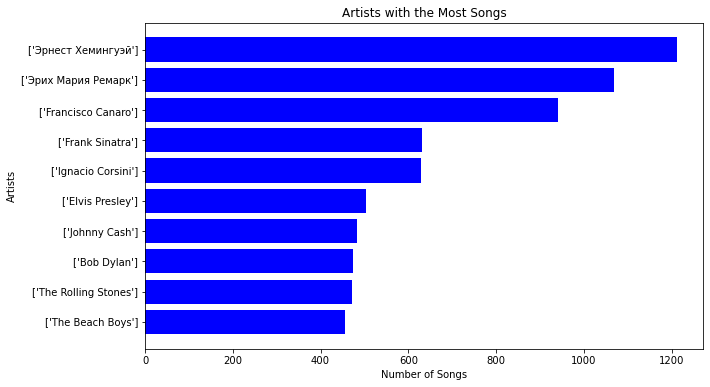

In [78]:
query7= spark.sql("""
    SELECT artists, COUNT(name) AS num_songs
    FROM  data
    GROUP BY artists
    ORDER By num_songs DESC
    LIMIT 10
""")
query7.show()

query7_df = query7.toPandas()

plt.figure(figsize=(10, 6))
plt.barh(query7_df["artists"], query7_df["num_songs"], color="blue")
plt.xlabel("Number of Songs")
plt.ylabel("Artists")
plt.title("Artists with the Most Songs")
plt.gca().invert_yaxis()
mplcursors.cursor(hover=True)
plt.show()

#Arists with most songs over time